In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy
from scipy.stats import norm
import tensorflow_probability as tfp
import seaborn as sns
import pandas as pd
import corner 
import math as m
import copy
from HessianMCMC import HessianMCMC

tfb = tfp.bijectors
tfd=tfp.distributions
psd_kernels = tfp.math.psd_kernels

In [2]:
def constant64(i):
    return(tf.constant(i,dtype = tf.float64))

#### Z direction gravity line integration following Won 1987
\begin{equation}
\Delta g_{z}=2 G \rho \sum_{i=1}^{n} Z_{i}
\end{equation}

\begin{equation}
Z=A\left[\left(\theta_{1}-\theta_{2}\right)+B \ln \frac{r_{2}}{r_{1}}\right]
\end{equation}

where,   
\begin{equation}
\begin{aligned}
&A=\frac{\left(x_{2}-x_{1}\right)\left(x_{1} z_{2}-x_{2} z_{1}\right)}{\left(x_{2}-x_{1}\right)^{2}+\left(z_{2}-z_{1}\right)^{2}}\\
&B=\frac{z_{2}-z_{1}}{x_{2}-x_{1}}
\end{aligned}
\end{equation}

and,   
\begin{equation}
\begin{aligned}
&r_{1}^{2}=x_{1}^{2}+z_{1}^{2}\\
&r_{2}^{2}=x_{2}^{2}+z_{2}^{2}
\end{aligned}
\end{equation}


In [3]:
def divide(a,b):
    '''
     Tensorflow safe divide
    '''
    return tf.math.divide_no_nan(a,b)

def A(x1,z1,x2,z2):
    numerator = (x2-x1)*(x1*z2-x2*z1)
    denominator = (x2-x1)**2 + (z2-z1)**2
    return divide(numerator,denominator)

def B(x1,z1,x2,z2):
    '''
    x : array, x coordinate
    z : array, z coordinate
    p1, p2 : int, position
    
    '''
    return divide((z1-z2),(x2-x1))


def theta_new(xn,zn):
    
    m = tf.atan(divide(zn,xn))

    m = tf.where(m<0, m + pi, m ) 

    m = tf.where(m == 0, m + pi/2, m)

    return m
 
    
def Z_new(x1,z1,x2,z2):
    
    ## let's do not allow 1) points at origin
    ##                    2) two points in a sequence have the same x coordinate
    
    
    theta1 = theta_new(x1,z1)
    theta2 = theta_new(x2,z2)
    
    r1 = (tf.sqrt(x1**2.+z1**2.))
    r2 = (tf.sqrt(x2**2.+z2**2.))

    _A = A(x1,z1,x2,z2)
    _B = B(x1,z1,x2,z2)
    
    
    Z_result = _A*((theta1-theta2)+_B*tf.math.log(divide(r1,r2)))
    

    return Z_result 
 
@tf.function
def grav_new(x,z):
    
    
    thick = thickness
    x_obv = tf.linspace(Range[0],Range[1],obs_N)
    y_obv = tf.zeros(tf.shape(x_obv),dtype = tf.float64)
    
    
    tx = tf.transpose(tf.tile(x,[1,obs_N]))

    x_tile = tf.expand_dims(tx,axis = 2)

    tz = tf.transpose(tf.tile(z,[1,obs_N]))

    z_tile = tf.expand_dims(tz,axis = 2)
    
    
    x_obv_tile = tf.expand_dims(x_obv,axis = 1)
    x_obv_tile = tf.tile(x_obv_tile,[1,x.shape[0]])
    x_obv_tile = tf.reshape(x_obv_tile,[obs_N,x.shape[0],1])


    z_obv_tile = tf.expand_dims(y_obv,axis = 1)
    z_obv_tile = tf.tile(z_obv_tile,[1,x.shape[0]])
    z_obv_tile = tf.reshape(z_obv_tile,[obs_N,x.shape[0],1])
    
    
    _x = x_tile - x_obv_tile
    _z = z_tile - z_obv_tile
    
    x_ = tf.concat([_x, tf.reshape(_x[:,0],shape = [obs_N,1,1])],axis = 1)
    z_ = tf.concat([_z, tf.reshape(_z[:,0],shape = [obs_N,1,1])],axis = 1)
    
    x1 = x_[:,0:-1]
    x2 = x_[:,1:]
    z1 = z_[:,0:-1]
    z2 = z_[:,1:]
    
    G = constant64(6.67 * 10**(-11)) # gravitational constant  m^3 kg ^-1 s^-2
    rho = constant64(2000.)        # density difference   kg/m^3
    
    gravity = 2*G*rho*tf.reduce_sum(-Z_new(x1,z1,x2,z2),axis = 1)
    
    return tf.squeeze(gravity)


In [4]:

@tf.function
def joint_log_post(D,_control_position):
    """
    D: is the observation data
    ps: Positions,Variable(N elements vector)
    """
    # define random variables prior
    
    mvn_prior = tfd.MultivariateNormalTriL(
            loc = mu_prior,
            scale_tril=tf.linalg.cholesky(cov_prior))
    # define likelihood

    _control_index = tf.linspace(constant64(-70),constant64(70),Number_para)
    __x,__z = GaussianProcess_model(kernel,observation_index_points,_control_index,_control_position)
    
    Gm_ = grav_new(__x,__z)
    
    mvn_likelihood = tfd.MultivariateNormalTriL(
            loc = Gm_,
            scale_tril= tf.linalg.cholesky(cov))
    
    # return the posterior probability
    return (mvn_prior.log_prob(_control_position)
            +mvn_likelihood.log_prob(D))

@tf.function
def negative_log_posterior(D,_control_position):
    return -joint_log_post(D,_control_position)

In [5]:
## define some numbers
Number_para = 2
obs_N = 25
number_burnin = 3000
number_sample = 10000
steps_gradient_decent = 2000

pi = constant64(m.pi) # define PI in Tensorflow form

depth = constant64(-50)
thickness = constant64(10)

Range = constant64([-200.,200.])

In [6]:
# prior
mu_prior = -50.*tf.ones([Number_para],dtype = tf.float64)
cov_prior = 15.*tf.eye(Number_para,dtype = tf.float64)

x_obv = tf.linspace(Range[0],Range[1],obs_N)


# likelihood
sig_e = constant64(2*1e-8)
cov = sig_e**2.*tf.eye(obs_N,dtype = tf.float64)

## Define the ground truth

In [7]:
tf.random.set_seed(8)

# X- values: uniformly distributed
control_index = tf.linspace(Range[0],Range[1],Number_para)
#control_index with non-even distribution
# control_index = tf.linspace(Range[0],Range[1],Number_para)+tf.random.uniform([Number_para],-20,20,dtype = tf.float64)

# define some points to minimize the artifacts
number_of_fixpoints = 10

fix_point1 = tf.transpose(tf.stack([tf.linspace(Range[0]-200,Range[0]-10,number_of_fixpoints),depth*tf.ones(number_of_fixpoints,dtype = tf.float64)]))
fix_point2 = tf.transpose(tf.stack([tf.linspace(Range[1]+10,Range[1]+200,number_of_fixpoints),depth*tf.ones(number_of_fixpoints,dtype = tf.float64)]))

## define the true z-values
True_position = tf.random.normal([Number_para],depth,10,dtype = tf.float64)
True_position_sin = 20*tf.sin(0.04*control_index)+depth

#### Gaussian Process

In [8]:
## train the gp model based on True_position


# define x , z
points = tf.stack([control_index,True_position],axis = -1)


# add some points to eliminate the bondary artifacts
points = tf.concat([tf.concat([fix_point1,points],axis = 0),fix_point2],axis = 0)

## define the GP parameters
amplitude = tfp.util.TransformedVariable(
      2, tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
      200, tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)
    
observation_noise_variance = tfp.util.TransformedVariable(
        np.exp(-.1), tfb.Exp(),dtype = tf.float64, name='observation_noise_variance')

# x- index used to construct GP model
observation_index_points = tf.reshape(points[:,0],[Number_para+2*number_of_fixpoints,1])


# We'll use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)

# optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)
# @tf.function
# def optimize():
#     with tf.GradientTape() as tape:
#         loss = -gp.log_prob(points[:,1])
#     grads = tape.gradient(loss, gp.trainable_variables)
#     optimizer.apply_gradients(zip(grads, gp.trainable_variables))
#     return loss
# # First train the model, then draw and plot posterior samples.
# for i in range(1000):
#     neg_log_likelihood_ = optimize()
    
    
model_index = tf.expand_dims(tf.linspace(observation_index_points[0,0],
                                         observation_index_points[-1,0],
                                         Number_para+4),
                             axis =1)
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=model_index,
    observation_index_points=observation_index_points,
    observations=points[:,1],
    observation_noise_variance=observation_noise_variance)

model_position = gprm.mean()

model_position_complete = tf.reshape([tf.concat([model_position - thickness,
                                                     tf.reverse(model_position,
                                                                axis = [-1])],
                                                axis = -1)],
                                         shape = [model_position.shape[0]*2,1])
model_index_complete = tf.concat([model_index,tf.reverse(model_index,
                                                         axis = [0])],
                                 axis = 0)

In [9]:
gp.trainable_variables

(<tf.Variable 'amplitude:0' shape=() dtype=float64, numpy=0.6931471805599453>,
 <tf.Variable 'length_scale:0' shape=() dtype=float64, numpy=5.298317366548036>,
 <tf.Variable 'observation_noise_variance:0' shape=() dtype=float64, numpy=-0.10000000000000006>)

Exponentiated Quadratic Kernel

In [10]:
def GaussianProcess_model(kernel,observation_index_points,_control_index,_control_position):
    '''
        Arguments:
            kernel: trained GP kernal
            
        return:
            GP interpolated model index and model psition
            
    '''
    ## define how many points interpolated between control points
    resolution = 5
    
    
    points = tf.stack([_control_index,_control_position],axis = -1)

    points = tf.concat([tf.concat([fix_point1,points],axis = 0),fix_point2],axis = 0)
    
    # x-index where we want to interpolate
    model_index = tf.expand_dims(tf.linspace(observation_index_points[0,0],observation_index_points[-1,0],resolution*Number_para+4),axis =1)

    gprm = tfd.GaussianProcessRegressionModel(
        kernel=kernel,
        index_points=model_index,
        observation_index_points=observation_index_points,
        observations=points[:,1],
        observation_noise_variance=observation_noise_variance)

    model_position = gprm.mean()

    ## model_complete contains the extended polygon used to do gravity calculation
    model_position_complete = tf.reshape([tf.concat([model_position - thickness,
                                                     tf.reverse(model_position,axis = [-1])],axis = -1)],
                                         shape = [model_position.shape[0]*2,1])

    model_index_complete = tf.concat([model_index,tf.reverse(model_index,axis = [0])],axis = 0)
    
    return model_index_complete,model_position_complete

x_true,z_true = GaussianProcess_model(kernel,observation_index_points,control_index,True_position_sin)

In [11]:
Data = grav_new(x_true,z_true)

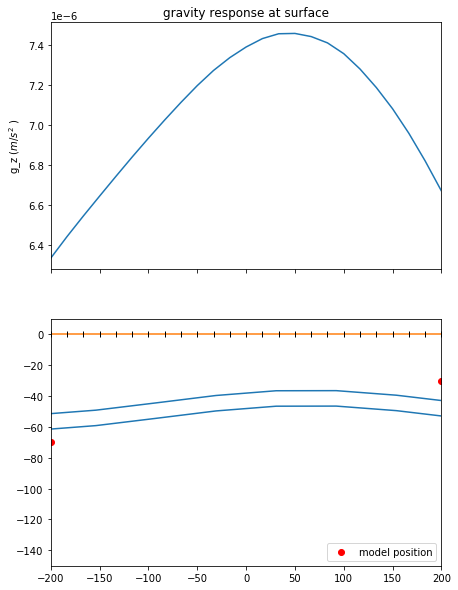

In [12]:
def simulated_gravity(x,z,x_obs=None,Number_=obs_N ,R=Range[1],ax = None,style = None,**args):
    if ax is None:
        f,ax=plt.subplots()
    if x_obs is None:
        x_obs = np.linspace(-R,R,Number_)
    y = np.zeros(np.shape(x_obs))
    obv = np.vstack((x_obs,y)).T

    gravity = grav_new(x,z)
    if style is None:
        style = '-'
    ax.set_title('gravity response at surface')
    ax.set_ylabel('g_z ($m/s^2$ )')

    ax.set_xlim(-R,R)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    ax.plot(x_obs,gravity,style,**args)
    return gravity

def Draw_inter(_control_index,_control_position,z_true = None,R = Range[1], ax = None):
    if ax is None:
        _,ax = plt.subplots(figsize = (14,7))
    if z_true is not None:
        ## true poistion is black
        ax.scatter(control_index,z_true, c = 'black',label = 'true position',alpha = 0.6)
        
    x_,z_ = GaussianProcess_model(kernel,observation_index_points,_control_index,_control_position)
    ax.plot(x_,z_)
    ## proposal is red
    ax.scatter(control_index,_control_position, label = 'model position',c = 'red')

    ax.plot(np.linspace(-R,R,obs_N),np.zeros(obs_N))
    ax.plot(np.linspace(-R,R,obs_N),np.zeros(obs_N),'k|')
    ax.set_ylim(depth-100,10)
    ax.set_xlim(-R,R)
    
def Draw(_control_index,_control_position,true_position = None,ax = None,**args):
    if ax is None:
        f,ax = plt.subplots(2,sharex=True, figsize = (7,10))
    _x,_z = GaussianProcess_model(kernel,observation_index_points,_control_index,_control_position)
    simulated_gravity(_x,_z,ax = ax[0],**args)
    Draw_inter(_control_index,_control_position,ax = ax[1],z_true =true_position)
    plt.legend(loc = 'lower right')
Draw(control_index,True_position_sin)

In [13]:
mu_init = tf.random.normal([Number_para],mean = depth, stddev = -10,seed = 2,dtype = tf.float64) # initial parameters
mu = mu_init

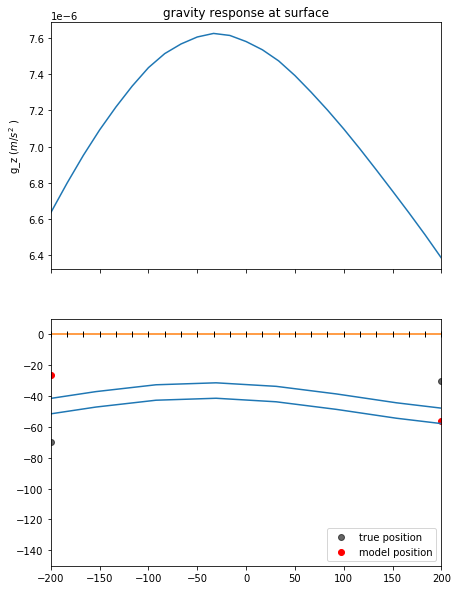

In [14]:
Draw(control_index,mu_init,True_position_sin)

In [15]:
mu = mu_init
with tf.GradientTape() as t:  
    t.watch(mu)
    loss = negative_log_posterior(Data,mu) # negative log posterior
    lost.append(loss.numpy())
    dlossdmu = t.gradient(loss,mu)
    print(dlossdmu)
mu = mu-tf.multiply(constant64(0.00001),dlossdmu)
Draw(control_index,mu,True_position_sin)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


NameError: name 'lost' is not defined

In [ ]:
steps_gradient_decent = 5000
lost = []
for i in range(steps_gradient_decent):
    with tf.GradientTape() as t:  
        t.watch(mu)
        loss = negative_log_posterior(Data,mu) # negative log posterior
        lost.append(loss.numpy())
        dlossdmu = t.gradient(loss,mu)
        print('mu',mu.numpy())
        print('loss',loss.numpy())
        print('dmu',dlossdmu.numpy())
    mu = mu-tf.multiply(constant64(0.0001),dlossdmu)
#     if i % 1000 == 0:
#         print('loss',loss)
#         print('grad',dlossdmu)
#         print('mu:',mu)
#         f,ax = plt.subplots()
#         Draw_inter(control_index,mu,ax = ax)
#         print('Iteration',i)
#         plt.show()
plt.plot(lost)
MAP = mu

In [ ]:
Draw(control_index,mu, True_position_sin)

## SVGD

In [ ]:
def svgd_kernel(X0):
    XY = tf.matmul(X0, tf.transpose(X0))
    X2_ = tf.reduce_sum(tf.square(X0), axis=1)

    x2 = tf.reshape(X2_, shape=(tf.shape(X0)[0], 1))

    X2e = tf.tile(x2, [1, tf.shape(X0)[0]])
    
    ## (x1 -x2)^2 + (y1 -y2)^2
    H = tf.subtract(tf.add(X2e, tf.transpose(X2e)), 2 * XY)

    V = tf.reshape(H, [-1, 1])

    # median distance
    def get_median(v):
        v = tf.reshape(v, [-1])
        m = v.get_shape()[0]//2
        return tf.nn.top_k(v, m).values[m-1]
    h = get_median(V)
    h = tf.sqrt(
        0.5 * h / tf.math.log(tf.cast(tf.shape(X0)[0], tf.float64) + 1.0))

    # compute the rbf kernel
    Kxy = tf.exp(-H / h ** 2 / 2.0)

    dxkxy = tf.negative(tf.matmul(Kxy, X0))
    sumkxy = tf.expand_dims(tf.reduce_sum(Kxy, axis=1), 1)
    dxkxy = tf.add(dxkxy, tf.multiply(X0, sumkxy)) / (h ** 2)

    return (Kxy, dxkxy)

In [ ]:
lr = constant64(0.004)
num_iter = 1000
num_particles = 200

In [ ]:
mu = tf.random.uniform([num_particles,Number_para],-200,-20,dtype = tf.float64)

In [ ]:
def gradient(mu):
    log_p_grad = tf.TensorArray(tf.float64, size=num_particles)
    for i in range(mu.shape[0]):
        with tf.GradientTape() as t:
            t.watch(mu)
            f = joint_log_post(Data,mu[i])
        log_p_grad =log_p_grad.write(i, t.gradient(f,mu)[i])
    return log_p_grad.stack()

In [ ]:
x = np.linspace(Range[0],Range[1],Number_para)
x = np.reshape(np.tile(x,num_particles),[num_particles,Number_para])

In [ ]:
@tf.function
def svgd_one_iter(mu):
    log_p_grad = gradient(mu)
    kernel_matrix, kernel_gradients = svgd_kernel(mu)
    grad_theta = (tf.matmul(kernel_matrix, log_p_grad) + kernel_gradients)/num_particles
    mu = mu+lr*grad_theta
    return mu

def run_chain_svgd(mu):
    for i in range(num_iter):
        mu = svgd_one_iter(mu)
    return mu

In [ ]:
mu = run_chain_svgd(mu)

In [ ]:
 _,ax = plt.subplots(figsize = (14,7))
ax.plot(x,mu,'k.')
Draw_inter(control_index,True_position_sin,ax=ax)

In [ ]:
log_p_grad = gradient(mu)
kernel_matrix, kernel_gradients = svgd_kernel(mu)
grad_theta = (tf.matmul(kernel_matrix, log_p_grad) + kernel_gradients)/num_particles
0.004*grad_theta


In [ ]:
sns.kdeplot(mu[:,1].numpy())
sns.kdeplot(mu[:,0].numpy())